# 1. 변수 선택을 위한 피쳐별 logloss 비교

In [24]:
!pip install ngboost

  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4034 sha256=6a06f22aeaea73668510e2cbdc63d08383481a945c9b364b48be1d3178df7dea
  Stored in directory: c:\users\lglaptop\appdata\local\pip\cache\wheels\16\a2\b6\582cfdfbeeccd469504a01af3bb952fd9e7eccba40995eafea
Successfully built autograd-gamma


In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# Machine learning 
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model, neighbors, svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, ExtraTreesClassifier
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, cross_val_score
from sklearn import model_selection
from vecstack import stacking
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from ngboost import NGBClassifier
from sklearn.metrics import log_loss, accuracy_score

%matplotlib inline # plt.show()를 하지 않아도 자동으로 생성되도록 만든다.

UsageError: unrecognized arguments: # plt.show()를 하지 않아도 자동으로 생성되도록 만든다.


In [4]:
def run_pipeline(data_df, target):
    #자동으로 num과 cat 변수 갈라서 df 생성
    data_df_cat = data_df.select_dtypes(include=np.object)
    data_df_num = data_df.select_dtypes(exclude=np.object)

    # binary df 만들어주기
    data_df_bi = data_df[['gender','car','reality','work_phone','phone','email','dup']]

    # cat인데 num df에 들어간 변수 num df에서 drop해주기
    data_df_num = data_df_num.drop(columns=['gender','car','reality','work_phone','phone','email','dup'])

    x_train, x_test, y_train, y_test = model_selection.train_test_split(data_df,
                                                                    target,
                                                                   test_size = 0.2,
                                                                   random_state=0)
    
    binary_features = data_df_bi.columns
    
    numeric_features = data_df_num.columns
    numeric_transformer = StandardScaler() # cf) RobustScaler

    categorical_features = data_df_cat.columns
    categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') # categories='auto' : just for ignoring warning messages

    preprocessor = ColumnTransformer(
        transformers=[ # List of (name, transformer, column(s))
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('bi','passthrough',binary_features)])

    preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])
    preprocessor_pipe.fit(x_train)

    x_train_transformed = preprocessor_pipe.transform(x_train)
    x_test_transformed = preprocessor_pipe.transform(x_test)

    return x_train_transformed, x_test_transformed, y_train, y_test

In [5]:
# Gradient Boosting 모델에 대해서 score와 logloss를 출력, logloss반환
from sklearn.metrics import log_loss, accuracy_score

def get_logloss_GBC(x_train_transformed, x_test_transformed, y_train, y_test):  
    params = {'n_estimators':1000, 'max_depth':4, 'min_samples_split':2,
      'learning_rate': 0.1, 'random_state': 0}


    # 모델 학습
    model = GradientBoostingClassifier(**params)
    model.fit(x_train_transformed, y_train)

    # test셋에 대해서 예측 정확도 출력
    x_pred = model.predict(x_test_transformed)
    accuracy = accuracy_score(x_pred, y_test)
    print("model score:", round(accuracy, 4))
    
    proba_result = model.predict_proba(x_test_transformed)
    print("proba_result :",proba_result)

    pro_logloss = log_loss(y_test, proba_result)
    print('logloss: ',pro_logloss)
    
    return pro_logloss

In [6]:
def get_logloss_XGB(x_train_transformed, x_test_transformed, y_train, y_test):  
    # 모델 학습
    random_state = 0
    model = XGBClassifier(objective='multi:softprob',num_classes=3,random_state=random_state )
    model.fit(x_train_transformed, y_train) # <- x_train_transformed (not x_train)

    # test셋에 대해서 예측 정확도 출력
    x_pred = model.predict(x_test_transformed)
    accuracy = accuracy_score(x_pred, y_test)
    print("model score:", round(accuracy, 4))
    
    proba_result = model.predict_proba(x_test_transformed)
    print("proba_result :",proba_result)

    pro_logloss = log_loss(y_test, proba_result)
    print('logloss: ',pro_logloss)
    
    return pro_logloss

In [7]:
def get_logloss_LGBM(x_train_transformed, x_test_transformed, y_train, y_test):
    # 모델 학습
    random_state = 0
    model = LGBMClassifier(random_state=random_state)
    model.fit(x_train_transformed, y_train) # <- x_train_transformed (not x_train)

    # test셋에 대해서 예측 정확도 출력
    x_pred = model.predict(x_test_transformed)
    accuracy = accuracy_score(x_pred, y_test)
    print("model score:", round(accuracy, 4))
    
    proba_result = model.predict_proba(x_test_transformed)
    print("proba_result :",proba_result)

    pro_logloss = log_loss(y_test, proba_result)
    print('logloss: ',pro_logloss)
    
    return pro_logloss

# 머신러닝 피처별 모델 비교


피처들을 제거했을때보다 그대로 활용했을때 logloss가 적게 나옴

## 01. 직업열을 최빈값으로 채웠을때

* pre_credit_dffill_groupby_old.csv
    * 드라이브 data에 올려놓았습니다
    * 전처리 내용 확정 전 데이터파일

In [21]:
data_df = pd.read_csv('pre_credit_dffill_groupby_old.csv')
target = data_df['credit']
data_df = data_df.drop(['credit'], axis=1)

In [22]:
data_df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,Age,dup,cards
0,0,0,0,0,0,12.218505,Commercial associate,Higher education,Married,Municipal apartment,4709,0,0,0,Laborers,2.0,6.0,38.079452,1,5
1,1,0,0,1,1,12.419174,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,0,0,1,Laborers,3.0,5.0,31.178082,1,9
2,2,1,1,1,0,13.017007,Working,Higher education,Married,House / apartment,4434,0,1,0,Managers,2.0,22.0,52.293151,1,6
3,3,0,0,1,0,12.218505,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,0,1,0,Sales staff,2.0,37.0,41.336986,1,2
4,4,0,1,1,0,11.967193,State servant,Higher education,Married,House / apartment,2105,0,0,0,Managers,2.0,26.0,41.197260,0,1


In [23]:
x_train_transformed, x_test_transformed, y_train, y_test = run_pipeline(data_df, target)

In [24]:
# GBC
pro_logloss = get_logloss_GBC(x_train_transformed, x_test_transformed, y_train, y_test)

model score: 0.7113
proba_result : [[0.19253043 0.54913261 0.25833696]
 [0.2124928  0.1122863  0.6752209 ]
 [0.09996602 0.18176523 0.71826876]
 ...
 [0.16646437 0.14562803 0.68790759]
 [0.04555345 0.0822485  0.87219805]
 [0.10149636 0.25429551 0.64420813]]
logloss:  0.750289981989438


In [25]:
# XGB
xgb_logloss = get_logloss_XGB(x_train_transformed, x_test_transformed, y_train, y_test)

[10:35:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:35:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


model score: 0.7037
proba_result : [[0.14380363 0.5485363  0.3076601 ]
 [0.1961342  0.11302324 0.69084257]
 [0.11760108 0.17532872 0.7070702 ]
 ...
 [0.26973787 0.175529   0.5547331 ]
 [0.05850275 0.09277759 0.8487197 ]
 [0.15711574 0.19290948 0.6499748 ]]
logloss:  0.7584312438971179


In [26]:
# LGBM
get_logloss_LGBM(x_train_transformed, x_test_transformed, y_train, y_test)

model score: 0.7031
proba_result : [[0.24966011 0.40244261 0.34789728]
 [0.15878244 0.11374586 0.7274717 ]
 [0.11102582 0.23088731 0.65808686]
 ...
 [0.25266617 0.18151704 0.56581679]
 [0.06786054 0.11139118 0.82074828]
 [0.12095737 0.20372998 0.67531265]]
logloss:  0.7522003427912881


0.7522003427912881

## 02. 직업열을 ML로 채웠을때

* pre_credit_dffill_ML_old.csv
    * 드라이브 data에 올려놓았습니다
    * 전처리 내용 확정 전 데이터파일

In [27]:
data_df = pd.read_csv('pre_credit_dffill_ML_old.csv')
target = data_df['credit']
data_df = data_df.drop(['credit'], axis=1)
data_df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,Age,dup,cards
0,0,0,0,0,0,12.218505,Commercial associate,Higher education,Married,Municipal apartment,4709,0,0,0,High skill tech staff,2.0,6.0,38.079452,1,5
1,1,0,0,1,1,12.419174,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,0,0,1,Laborers,3.0,5.0,31.178082,1,9
2,2,1,1,1,0,13.017007,Working,Higher education,Married,House / apartment,4434,0,1,0,Managers,2.0,22.0,52.293151,1,6
3,3,0,0,1,0,12.218505,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,0,1,0,Sales staff,2.0,37.0,41.336986,1,2
4,4,0,1,1,0,11.967193,State servant,Higher education,Married,House / apartment,2105,0,0,0,Managers,2.0,26.0,41.197260,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,12.323865,State servant,Secondary / secondary special,Married,House / apartment,1984,0,0,0,Core staff,4.0,2.0,33.093151,1,5
26453,26453,0,0,1,1,12.100723,Working,Higher education,Separated,House / apartment,2475,0,0,0,Core staff,2.0,47.0,41.893151,0,1
26454,26454,0,1,0,0,12.586227,Working,Secondary / secondary special,Civil marriage,With parents,2015,0,0,0,Core staff,2.0,25.0,27.621918,0,1
26455,26455,1,0,1,0,12.049431,Working,Incomplete higher,Single / not married,House / apartment,107,0,0,0,Laborers,1.0,59.0,27.794521,0,1


In [28]:
x_train_transformed, x_test_transformed, y_train, y_test = run_pipeline(data_df, target)

In [29]:
# GBC
pro_logloss = get_logloss_GBC(x_train_transformed, x_test_transformed, y_train, y_test)

model score: 0.7099
proba_result : [[0.24639096 0.56067398 0.19293506]
 [0.18534298 0.10426497 0.71039206]
 [0.1234076  0.23043188 0.64616051]
 ...
 [0.22919343 0.1334627  0.63734386]
 [0.06669923 0.08847617 0.8448246 ]
 [0.12243065 0.23232722 0.64524212]]
logloss:  0.7518860863360074


In [30]:
# XGB
xgb_logloss = get_logloss_XGB(x_train_transformed, x_test_transformed, y_train, y_test)

[10:39:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:39:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model score: 0.7048
proba_result : [[0.19630133 0.5233174  0.28038126]
 [0.25430068 0.2661227  0.4795766 ]
 [0.13238175 0.21151014 0.65610814]
 ...
 [0.16521311 0.20796701 0.62681985]
 [0.07522544 0.11421774 0.8105568 ]
 [0.12955248 0.1927587  0.67768884]]
logloss:  0.7578411372723403


In [31]:
# LGBM
get_logloss_LGBM(x_train_transformed, x_test_transformed, y_train, y_test)

model score: 0.702
proba_result : [[0.21029429 0.42893165 0.36077406]
 [0.1774394  0.16922913 0.65333148]
 [0.10601343 0.24551631 0.64847025]
 ...
 [0.20908237 0.18410122 0.60681641]
 [0.05831963 0.11006026 0.83162011]
 [0.10940394 0.17155305 0.71904301]]
logloss:  0.7567495333800214


0.7567495333800214

### 아래부터 전부 최빈값으로 채운 파일을 사용
## 03. occyp_type 제거

In [32]:
data_df = pd.read_csv('pre_credit_df(fill_groupby).csv')
target = data_df['credit']
data_df = data_df.drop(['credit'], axis=1)

data_df_del_occyp = data_df.drop(['occyp_type'], axis=1)
data_df_del_occyp

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,Age,dup,cards
0,0,0,0,0,0,12.218505,Commercial associate,Higher education,Married,Municipal apartment,4709,0,0,0,2.0,6.0,38.079452,1,5
1,1,0,0,1,1,12.419174,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,0,0,1,3.0,5.0,31.178082,1,9
2,2,1,1,1,0,13.017007,Working,Higher education,Married,House / apartment,4434,0,1,0,2.0,22.0,52.293151,1,6
3,3,0,0,1,0,12.218505,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,0,1,0,2.0,37.0,41.336986,1,2
4,4,0,1,1,0,11.967193,State servant,Higher education,Married,House / apartment,2105,0,0,0,2.0,26.0,41.197260,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,12.323865,State servant,Secondary / secondary special,Married,House / apartment,1984,0,0,0,4.0,2.0,33.093151,1,5
26453,26453,0,0,1,1,12.100723,Working,Higher education,Separated,House / apartment,2475,0,0,0,2.0,47.0,41.893151,0,1
26454,26454,0,1,0,0,12.586227,Working,Secondary / secondary special,Civil marriage,With parents,2015,0,0,0,2.0,25.0,27.621918,0,1
26455,26455,1,0,1,0,12.049431,Working,Incomplete higher,Single / not married,House / apartment,107,0,0,0,1.0,59.0,27.794521,0,1


In [33]:
x_train_transformed, x_test_transformed, y_train, y_test = run_pipeline(data_df_del_occyp, target)

In [34]:
# GBC
pro_logloss = get_logloss_GBC(x_train_transformed, x_test_transformed, y_train, y_test)

model score: 0.7073
proba_result : [[0.19978546 0.62226832 0.17794622]
 [0.20078572 0.08143067 0.71778361]
 [0.13221115 0.18697141 0.68081744]
 ...
 [0.19819948 0.15221955 0.64958097]
 [0.06225055 0.06812585 0.8696236 ]
 [0.08484535 0.17060914 0.74454551]]
logloss:  0.7541012406744527


In [35]:
# XGB
get_logloss_XGB(x_train_transformed, x_test_transformed, y_train, y_test)

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:41:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model score: 0.7035
proba_result : [[0.1963493  0.4738076  0.32984316]
 [0.23869625 0.09517054 0.6661332 ]
 [0.12628047 0.22073491 0.6529846 ]
 ...
 [0.13557115 0.19645754 0.6679713 ]
 [0.14813362 0.09179087 0.7600755 ]
 [0.13572375 0.19648865 0.66778755]]
logloss:  0.

0.759590353839098

In [36]:
# LGBM
get_logloss_LGBM(x_train_transformed, x_test_transformed, y_train, y_test)

model score: 0.7031
proba_result : [[0.19769585 0.35602534 0.44627881]
 [0.23360068 0.10960075 0.65679858]
 [0.13292946 0.2210608  0.64600974]
 ...
 [0.14992546 0.20513076 0.64494378]
 [0.07494755 0.13443278 0.79061967]
 [0.10572905 0.19211107 0.70215988]]
logloss:  0.757500239372338


0.757500239372338

## 04. adult_num 추가
- adult_num = family_size - child_num

In [37]:
data_df_adult = data_df.copy()
data_df_adult['adult_num'] = data_df['family_size'] - data_df['child_num']
data_df_adult = data_df_adult.drop(['child_num', 'family_size'], axis=1)
data_df_adult

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,begin_month,Age,dup,cards,adult_num
0,0,0,0,0,12.218505,Commercial associate,Higher education,Married,Municipal apartment,4709,0,0,0,Laborers,6.0,38.079452,1,5,2.0
1,1,0,0,1,12.419174,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,0,0,1,Laborers,5.0,31.178082,1,9,2.0
2,2,1,1,1,13.017007,Working,Higher education,Married,House / apartment,4434,0,1,0,Managers,22.0,52.293151,1,6,2.0
3,3,0,0,1,12.218505,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,0,1,0,Sales staff,37.0,41.336986,1,2,2.0
4,4,0,1,1,11.967193,State servant,Higher education,Married,House / apartment,2105,0,0,0,Managers,26.0,41.197260,0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,12.323865,State servant,Secondary / secondary special,Married,House / apartment,1984,0,0,0,Core staff,2.0,33.093151,1,5,2.0
26453,26453,0,0,1,12.100723,Working,Higher education,Separated,House / apartment,2475,0,0,0,Laborers,47.0,41.893151,0,1,1.0
26454,26454,0,1,0,12.586227,Working,Secondary / secondary special,Civil marriage,With parents,2015,0,0,0,Core staff,25.0,27.621918,0,1,2.0
26455,26455,1,0,1,12.049431,Working,Incomplete higher,Single / not married,House / apartment,107,0,0,0,Laborers,59.0,27.794521,0,1,1.0


In [38]:
x_train_transformed, x_test_transformed, y_train, y_test = run_pipeline(data_df_adult, target)

In [39]:
# GBC
pro_logloss = get_logloss_GBC(x_train_transformed, x_test_transformed, y_train, y_test)

model score: 0.7082
proba_result : [[0.22737941 0.49624675 0.27637383]
 [0.22348915 0.11469819 0.66181267]
 [0.07839266 0.24982309 0.67178424]
 ...
 [0.18229039 0.1485017  0.66920791]
 [0.07096014 0.07386848 0.85517138]
 [0.09071119 0.16854357 0.74074524]]
logloss:  0.7527456076221383


In [40]:
# XGB
get_logloss_XGB(x_train_transformed, x_test_transformed, y_train, y_test)

[10:45:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:45:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model score: 0.706
proba_result : [[0.2055155  0.5443319  0.25015256]
 [0.2893894  0.13776582 0.5728448 ]
 [0.10852671 0.19257715 0.69889617]
 ...
 [0.18629302 0.20610397 0.607603  ]
 [0.11500954 0.08921435 0.7957761 ]
 [0.10546626 0.19318508 0.70134866]]
logloss:  0.7580645926897178


0.7580645926897178

In [41]:
# LGBM
get_logloss_LGBM(x_train_transformed, x_test_transformed, y_train, y_test)

model score: 0.7031
proba_result : [[0.27932041 0.3490269  0.37165268]
 [0.21084336 0.09727502 0.69188162]
 [0.11386628 0.20368057 0.68245315]
 ...
 [0.2198465  0.18652931 0.59362418]
 [0.10911341 0.10754236 0.78334423]
 [0.12529702 0.18475267 0.68995031]]
logloss:  0.7559129716949955


0.7559129716949955

## 05. child_num 제거

In [42]:
# occyp_type 
data_df = pd.read_csv('pre_credit_df(fill_groupby).csv')
target = data_df['credit']
data_df = data_df.drop(['credit'], axis=1)

data_df_del_child = data_df.drop(['child_num'],axis=1).copy()
data_df_del_child.head()

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,Age,dup,cards
0,0,0,0,0,12.218505,Commercial associate,Higher education,Married,Municipal apartment,4709,0,0,0,Laborers,2.0,6.0,38.079452,1,5
1,1,0,0,1,12.419174,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,0,0,1,Laborers,3.0,5.0,31.178082,1,9
2,2,1,1,1,13.017007,Working,Higher education,Married,House / apartment,4434,0,1,0,Managers,2.0,22.0,52.293151,1,6
3,3,0,0,1,12.218505,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,0,1,0,Sales staff,2.0,37.0,41.336986,1,2
4,4,0,1,1,11.967193,State servant,Higher education,Married,House / apartment,2105,0,0,0,Managers,2.0,26.0,41.197260,0,1


In [43]:
x_train_transformed, x_test_transformed, y_train, y_test = run_pipeline(data_df_del_child, target)

In [44]:
# GBC
pro_logloss = get_logloss_GBC(x_train_transformed, x_test_transformed, y_train, y_test)

model score: 0.7107
proba_result : [[0.18799212 0.52431862 0.28768926]
 [0.15082286 0.09478234 0.7543948 ]
 [0.08880912 0.16414491 0.74704597]
 ...
 [0.1988185  0.14719535 0.65398615]
 [0.05107444 0.0743642  0.87456136]
 [0.09425268 0.20800117 0.69774615]]
logloss:  0.7482970071023473


In [45]:
# XGB
get_logloss_XGB(x_train_transformed, x_test_transformed, y_train, y_test)

[10:49:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:49:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


model score: 0.7045
proba_result : [[0.1812293  0.5196264  0.2991443 ]
 [0.18767416 0.09564636 0.7166795 ]
 [0.17886592 0.16866575 0.6524683 ]
 ...
 [0.2324753  0.14282368 0.62470096]
 [0.07871915 0.09798144 0.82329947]
 [0.15244046 0.1516351  0.69592446]]
logloss:  0.7580161056360223


0.7580161056360223

In [46]:
# LGBM
get_logloss_LGBM(x_train_transformed, x_test_transformed, y_train, y_test)

model score: 0.7043
proba_result : [[0.25032744 0.35003819 0.39963438]
 [0.17507946 0.1046566  0.72026394]
 [0.12467876 0.26002728 0.61529396]
 ...
 [0.32541359 0.16717606 0.50741036]
 [0.08422459 0.12895444 0.78682097]
 [0.10998418 0.19462931 0.69538652]]
logloss:  0.7569743695508185


0.7569743695508185

## SMOTE 적용

<AxesSubplot:>

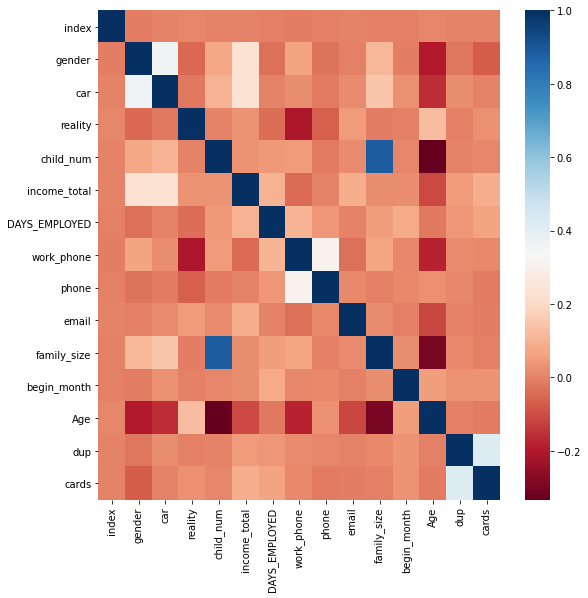

In [47]:
plt.figure(figsize=(9, 9))
sns.heatmap(data_df.corr(), cmap='RdBu')

In [48]:
from imblearn.over_sampling import SMOTE

In [49]:
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(x_train_transformed, y_train)

In [50]:
print('SMOTE 적용 전 레이블 값 분포:')
print(y_train.value_counts())

SMOTE 적용 전 레이블 값 분포:
2.0    13558
1.0     5029
0.0     2578
Name: credit, dtype: int64


In [51]:
print('SMOTE 적용 후 레이블 값 분포:')
print(y_train_over.value_counts())

SMOTE 적용 후 레이블 값 분포:
0.0    13558
2.0    13558
1.0    13558
Name: credit, dtype: int64


In [52]:
smote_xgb_logloss = get_logloss_XGB(X_train_over, x_test_transformed, y_train_over, y_test)

[10:49:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:49:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


model score: 0.7009
proba_result : [[0.24114464 0.51196086 0.24689451]
 [0.3056403  0.09759693 0.5967628 ]
 [0.17722435 0.25299367 0.56978196]
 ...
 [0.22432776 0.17418368 0.6014886 ]
 [0.12077165 0.14304818 0.7361802 ]
 [0.22422035 0.1650538  0.6107259 ]]
logloss:  0.7784778498277175


In [53]:
# LGBM
get_logloss_LGBM(X_train_over, x_test_transformed, y_train_over, y_test)

model score: 0.7046
proba_result : [[0.26747158 0.49307836 0.23945006]
 [0.23211663 0.12256849 0.64531488]
 [0.16272432 0.29040252 0.54687316]
 ...
 [0.2590952  0.19926347 0.54164133]
 [0.1037327  0.16293443 0.73333287]
 [0.20332387 0.21637876 0.58029737]]
logloss:  0.7876981984147629


0.7876981984147629

**[특정 피쳐별 logloss 비교 결과]** <br>

 1. 직업열 결측치: 최빈값으로 채운 것이 성능에 더 좋은 결과를 보임.
 2. 직업 타입 변수 제거: 제거시 성능이 떨어짐. 가지고 감
 3. (new) adult_num : 가족수에서 아이수를 뺀 성인수를 따로 만들어보기
     -> 성능의 큰 변화가 없어서 제외
 4. child_num : 필요함.
      대신 0, 1, 다자녀 카테고리컬 변수로 수정 후 이용
 

# 2. id열 탐색을 위한 트리기반 모델 시각화

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
import math
import graphviz

import collections
# from pydot import Dot, Node, Edge

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# Plot the Figures Inline
%matplotlib inline  # plt.show()를 하지 않아도 자동으로 생성되도록 만든다.

UsageError: unrecognized arguments: # plt.show()를 하지 않아도 자동으로 생성되도록 만든다.


In [2]:
# id가 삭제되지 않은 csv 파일 불러오기
data_df_id = pd.read_csv('pre_credit_df(fill_groupby)_withID.csv', index_col=0) # 엑셀 파일 읽기
data_df_id.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_EMPLOYED', 'work_phone',
       'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'credit',
       'Age', 'id', 'dup', 'cards', 'family_category', 'occyp_category'],
      dtype='object')

In [3]:
data_df_id.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,occyp_type,family_size,begin_month,credit,Age,id,dup,cards,family_category,occyp_category
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,4709,...,Laborers,2.0,6.0,1.0,38.079452,1,1,5,small,1.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,...,Laborers,3.0,5.0,1.0,31.178082,2,1,9,small,1.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,4434,...,Managers,2.0,22.0,2.0,52.293151,3,1,6,small,0.0
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,...,Sales staff,2.0,37.0,0.0,41.336986,4,1,2,small,1.0
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,2105,...,Managers,2.0,26.0,2.0,41.197260,5,0,1,small,0.0


In [100]:
# conda install python-graphviz

### graphviz 설치시 미리 읽기! 주의
tree모양 시각화를 하면 에러가 많이 납니다... graphviz의 경로 문제 때문인것 같은데<br> Graphviz 실행 파일을 
셀에서 `!pip install graphviz`로 설치하지 마시고<br>
아래 셀의 `conda install python-graphviz`를 실행하세요

In [27]:
# conda install python-graphviz

^C

Note: you may need to restart the kernel to use updated packages.


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import model_selection, svm

from sklearn.tree import export_graphviz
import graphviz

In [48]:
X=data_df_id.drop('credit', axis=1)
y=data_df_id[['credit']]

In [49]:
print(X.shape, y.shape)

(26451, 22) (26451, 1)


In [50]:
X.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_EMPLOYED', 'work_phone',
       'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'Age',
       'id', 'dup', 'cards', 'family_category', 'occyp_category'],
      dtype='object')

In [51]:
X.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,email,occyp_type,family_size,begin_month,Age,id,dup,cards,family_category,occyp_category
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,4709,...,0,Laborers,2.0,6.0,38.079452,1,1,5,small,1.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,...,1,Laborers,3.0,5.0,31.178082,2,1,9,small,1.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,4434,...,0,Managers,2.0,22.0,52.293151,3,1,6,small,0.0
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,...,0,Sales staff,2.0,37.0,41.336986,4,1,2,small,1.0
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,2105,...,0,Managers,2.0,26.0,41.197260,5,0,1,small,0.0


In [52]:
def run_pipeline(X, y):

    # binary df 만들어주기 = pass through 위해 id도 여기 넣어주기
    X_bi = X[['gender','car','reality','work_phone','phone','email','id', 'dup']]

    X_cat = X[['child_num', 'income_type','edu_type', 'family_type','house_type','occyp_type','family_category', 'occyp_category']]
    
    # cat인데 num df에 들어간 변수 num df에서 drop해주기
    X_num = X[['income_total','DAYS_EMPLOYED','family_size','begin_month', 'Age','cards']]

    
    x_train, x_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = 0.2,
                                                        random_state=0)
    
    binary_features = X_bi.columns
    
    numeric_features = X_num.columns
    numeric_transformer = StandardScaler() # cf) RobustScaler

    categorical_features = X_cat.columns
    categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') # categories='auto' : just for ignoring warning messages

    preprocessor = ColumnTransformer(
        transformers=[ # List of (name, transformer, column(s))
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
             ('bi','passthrough',binary_features)])

    preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])
    preprocessor_pipe.fit(x_train)

    x_train_transformed = preprocessor_pipe.transform(x_train)
    x_test_transformed = preprocessor_pipe.transform(x_test)

    return x_train_transformed, x_test_transformed, y_train, y_test, preprocessor

In [53]:
x_train_transformed, x_test_transformed, y_train, y_test, preprocessor = run_pipeline(X, y)

## 1. Decision Tree Classification

In [12]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(x_train_transformed,y_train)
model.score(x_test_transformed,y_test) #accuracy

0.7011907011907011

### 인코딩한 Dataframe 열 이름 생성

In [54]:
def get_feature_names(column_transformer):

    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [55]:
new_col_names = get_feature_names(preprocessor)
x_train_transformed = pd.DataFrame(x_train_transformed,columns=new_col_names)
x_test_transformed = pd.DataFrame(x_test_transformed,columns=new_col_names)

In [56]:
x_train_transformed.head()

,num__income_total,num__DAYS_EMPLOYED,num__family_size,num__begin_month,num__Age,num__cards,cat__x0_0,cat__x0_1,cat__x0_2,cat__x1_Commercial associate,...,cat__x7_1.0,cat__x7_2.0,gender,car,reality,work_phone,phone,email,id,dup
0,-0.292256,-0.018888,0.960995,2.045257,-0.955031,-0.052247,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,13.0,1.0
1,-0.911695,-0.930188,-0.209143,1.441287,1.833038,-0.872796,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,7735.0,1.0
2,0.371428,-0.930188,-0.209143,0.293742,1.074171,-0.872796,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,428.0,1.0
3,-0.955941,0.524857,-0.209143,1.803669,-1.387683,-0.872796,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4302.0,1.0
4,0.990867,-0.930188,-1.379280,-0.793405,1.390385,-0.872796,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2082.0,1.0


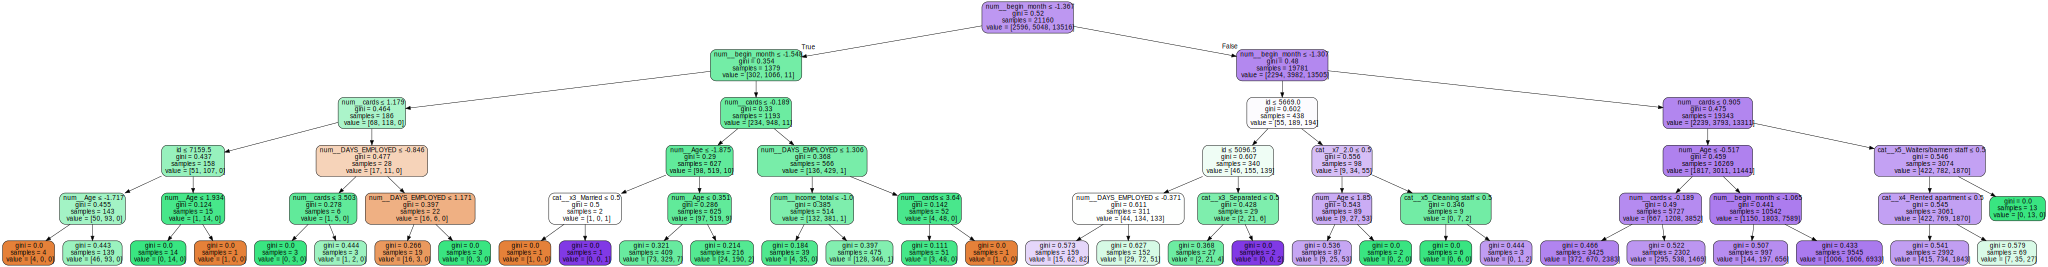

In [16]:
dot_data = export_graphviz(model,   # 의사결정나무 모형 대입
                           out_file = None,  # file로 변환할 것인가
                           feature_names = x_train_transformed.columns,  # feature 이름
                           class_names = None,  # target 이름
                           filled = True,           # 그림에 색상사용 여부
                           rounded = True,          # 반올림을 진행 여부
                           special_characters = True)   # 특수문자를 사용여부

graph = graphviz.Source(dot_data)              
graph

In [18]:
graph.render(filename='tree1')

'tree1.pdf'

Feature importances:
[1.6700e-03 1.1090e-02 0.0000e+00 8.9162e-01 2.0530e-02 4.4330e-02
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 8.2000e-04 2.0400e-03 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.6700e-03 0.0000e+00
 0.0000e+00 1.4600e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 1.0120e-02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 2.5100e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 7.1400e-03 0.0000e+00]
num__income_total : 0.002
num__DAYS_EMPLOYED : 0.011
num__family_size : 0.000
num__begin_month : 0.892
num__Age : 0.021
num__cards : 0.044
cat__x0_0 : 0.000
cat__x0_1 : 0.000
cat__x0_2 : 0.000
cat__x1_Commercial associate : 0.000
cat__x1_Pensioner : 0.000
cat__x1_State serv

<AxesSubplot:>

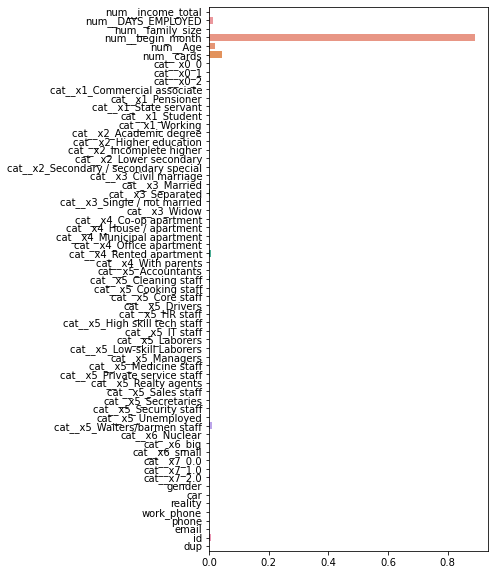

In [19]:
plt.figure(figsize = (5,10))

# feature importance 추출 
print("Feature importances:\n{0}".format(np.round(model.feature_importances_, 5)))

# feature별 importance 매핑
for name, value in zip(x_train_transformed.columns , model.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화 하기 
sns.barplot(x=model.feature_importances_ , y=x_train_transformed.columns)

## XGB 사용해서 ID 분기점 확인

In [20]:
# new_col_names = get_feature_names(preprocessor)
# x_train_transformed = pd.DataFrame(x_train_transformed,columns=new_col_names)
# x_test_transformed = pd.DataFrame(x_test_transformed,columns=new_col_names)

In [57]:
from xgboost import XGBClassifier

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

model_xgb = XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=500, 
                        num_classes=3)

model_xgb.fit(x_train_transformed, y_train)  

print('logloss on Training set: ',log_loss(y_train, model_xgb.predict_proba(x_train_transformed)))
print('accuracy on Training set: ',accuracy_score(y_train, model_xgb.predict(x_train_transformed)))

print('logloss on Test set: ', log_loss(y_test, model_xgb.predict_proba(x_test_transformed)))
print('accuracy on Test set: ', accuracy_score(y_test, model_xgb.predict(x_test_transformed)))

[23:14:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:14:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
logloss on Training set:  0.34541613394758075
accuracy on Training set:  0.8803875236294896
logloss on Test set:  0.723629107111749
accuracy on Test set:  0.7308637308637309


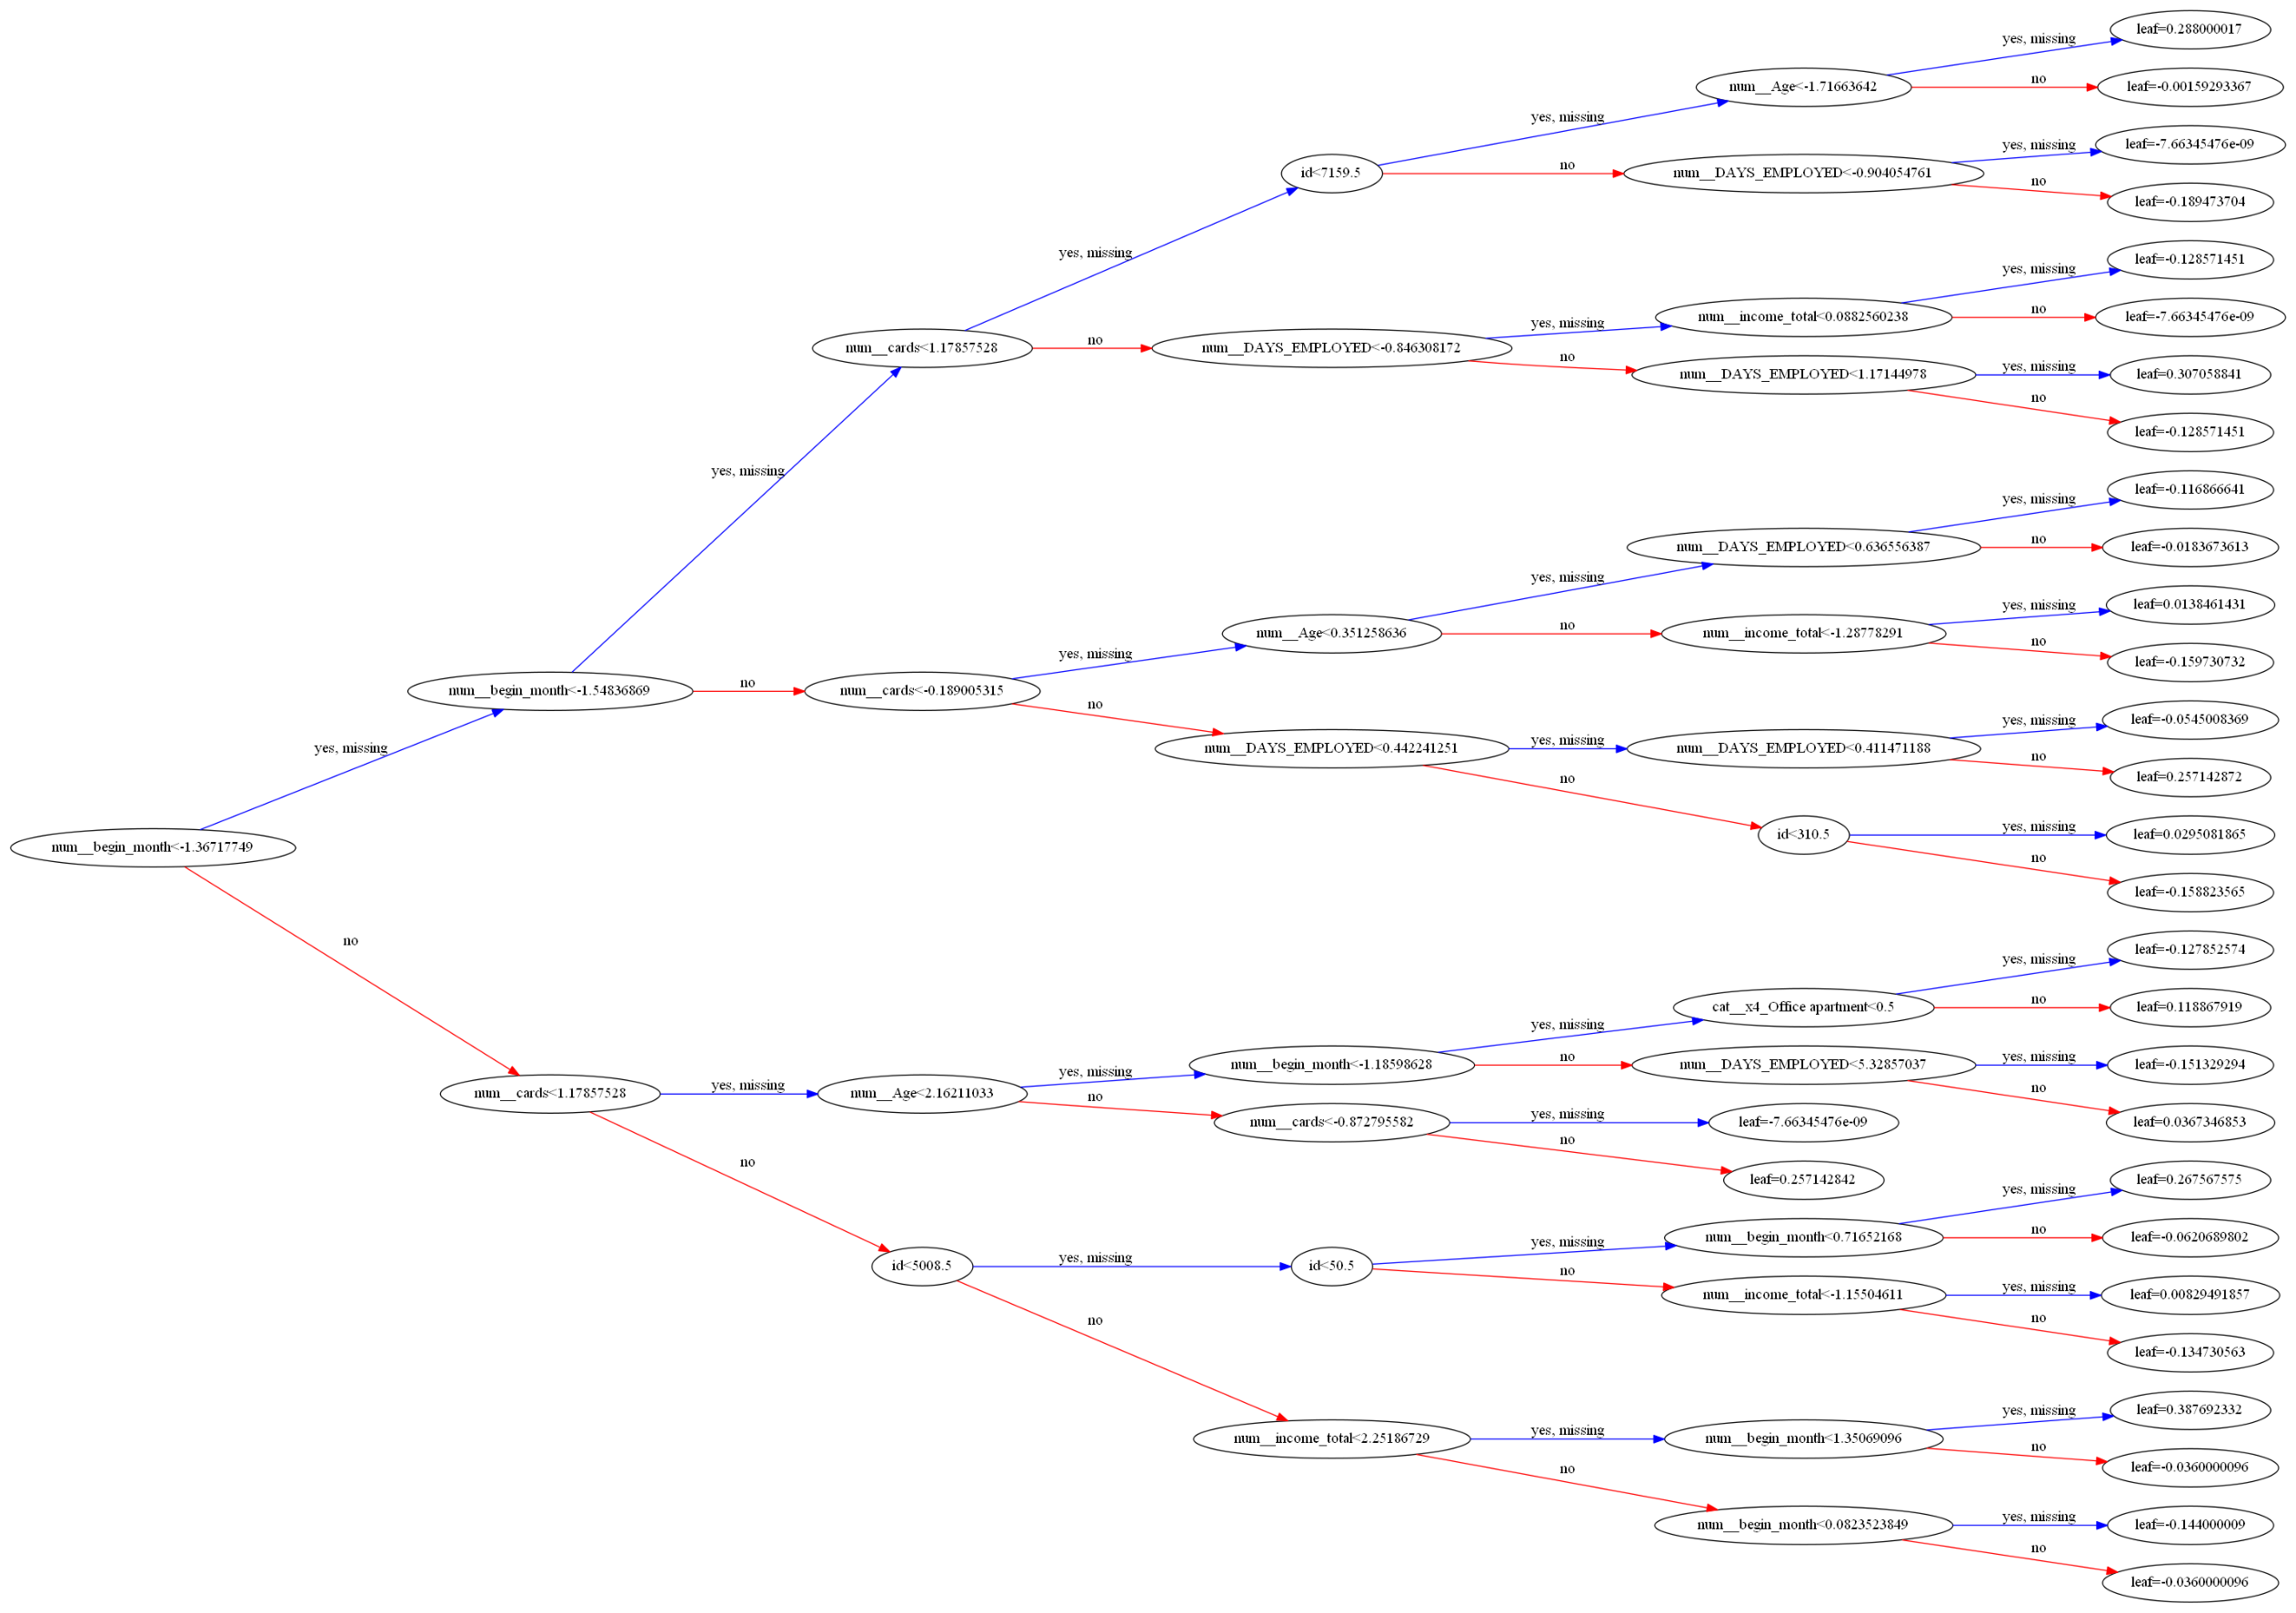

In [58]:
# https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/
from xgboost import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [45,100]

plot_tree(model_xgb, num_trees=0, rankdir='LR')
plt.show()

**[ID 탐색 결론 with 강사님]** <br>
* id는 1~8759까지 존재. 트리기반 모델에서 id를 주요 변수로 사용함
    * decision tree랑 같이 보면 50, 2963, 4156, 5000, 5540, 8281 등에서 갈라지는 것을 확인 <br>
* 그룹화??
    * 파생변수를 만든다고 해도 각 분기점 사이에 있는 숫자들은 우연히 같은 그룹에 들어갔을 뿐 그룹화에 대한 명확한 논리적 근거가 없음 <br>
* 데이콘은?
    * id열을 숫자형 변수로 써서 성능이 높게 나왔지만,<br>
    실제적으로 상용화한다면 새로운 test 데이터들은 8759 이후의 id를 부여받게 되는데, 이 또한 값의 의미 없음 <br>
* 결론: **배제하기로 결정함** <br>
    * id열은 카드 중복 소지 여부, 중복 소지 카드의 갯수 파생변수를 만드는 것에만 사용하고,

강사님 피드백)
1. p-hacking : 성능에 맞춰서 데이터를 트는 것 --> id를 그룹화 하는 것이 성능을 보고 그에 맞게 조작하는 것이므로 p-hacking의 모습이 보임

2. test 데이터가 들어올 때 dup과 num_cards는 train data에서만 비교해서 생성해야할까, 새롭게 들어온 test data들 안에서도 중복 유저를 찾아서 처리해야할까? : 1건에 대한 예측 결과를 낼 때, 각 독립사건으로 간주하고, 어떤 정보가 들어오는 지는 우연에 기반하므로 한 행당 train 데이터만 가지고 dup여부, 카드 갯수 값 생성